<a href="https://colab.research.google.com/github/angshumancertified/Solar-PV-forecast-with-Machine-Learning-/blob/main/solarpv_foreca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solar PV Output Prediction with Machine Learning
Built for 6th semester Minor Project <br>
Built by: Angshuman Talukdar <br>
Electrical Engineering, 2103004


Importing dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Load dataset

In [2]:
df = pd.read_csv("/content/Solar Power Plant Data.csv")

Data Preprocessing

In [5]:
def preprocess_data(df):

  #dropping date-hour column as it is not necessary
  df = df.drop(columns=['Date-Hour(NMT)'])

  #normalize the data
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(df)

  return scaled_data, scaler

scaled_data, scaler = preprocess_data(df)

Define function to create dataset for LSTM

In [11]:
def create_dataset(data, time_steps=1):
  X, y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i:(i + time_steps), :])
    y.append(data[i + time_steps, -1]) # Assuming the last column is system production
  return np.array(X), np.array(y)

Create dataset with time steps

In [12]:
time_steps = 24 # Assuming we want to predict based on the past 24 hours
X, y = create_dataset(scaled_data, time_steps)

Split data into train and test sets

In [15]:
split_ratio = 0.8
split = int(split_ratio * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Define and train LSTM model

In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
175/175 [==============================] - 10s 30ms/step - loss: 0.0178 - val_loss: 0.0094
Epoch 2/50
175/175 [==============================] - 4s 22ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 3/50
175/175 [==============================] - 5s 27ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 4/50
175/175 [==============================] - 4s 21ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 5/50
175/175 [==============================] - 4s 25ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 6/50
175/175 [==============================] - 7s 38ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 7/50
175/175 [==============================] - 4s 22ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 8/50
175/175 [==============================] - 4s 22ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 9/50
175/175 [==============================] - 5s 27ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 10/50
175/175 [==============================] - 4s 21ms/step - loss: 0.0048 - val_l

Plot training history

<function matplotlib.pyplot.show(close=None, block=None)>

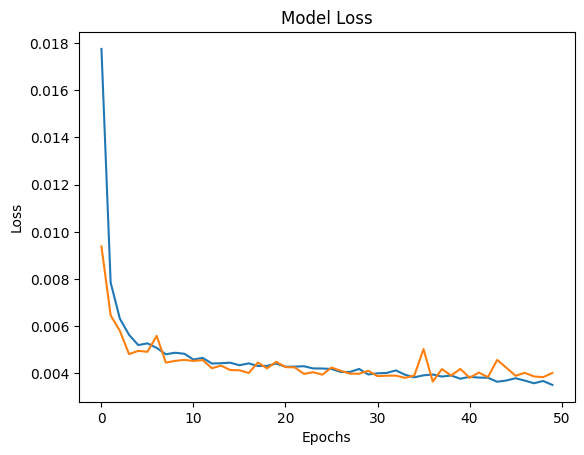

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend
plt.show

Make Predictions

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

55/55 [==============================] - 0s 7ms/step


Inverse scaling for predictions

In [25]:
train_predict = scaler.inverse_transform(np.concatenate((X_train[:, -1, :-1], train_predict.reshape(-1,1)), axis=1))[:, -1]
test_predict = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], test_predict.reshape(-1, 1)), axis=1))[:, -1]

Calculate RMSE

In [30]:
train_rmse = np.sqrt(mean_squared_error(df.iloc[time_steps:split+time_steps, -1], train_predict))
test_rmse = np.sqrt(mean_squared_error(df.iloc[split+time_steps:, -1], test_predict))
print("Train RMSE:", train_rmse)
print("Test RMSE", test_rmse)

Train RMSE: 13131005.00735364
Test RMSE 255.61508218645415


Plotting actual vs predicted

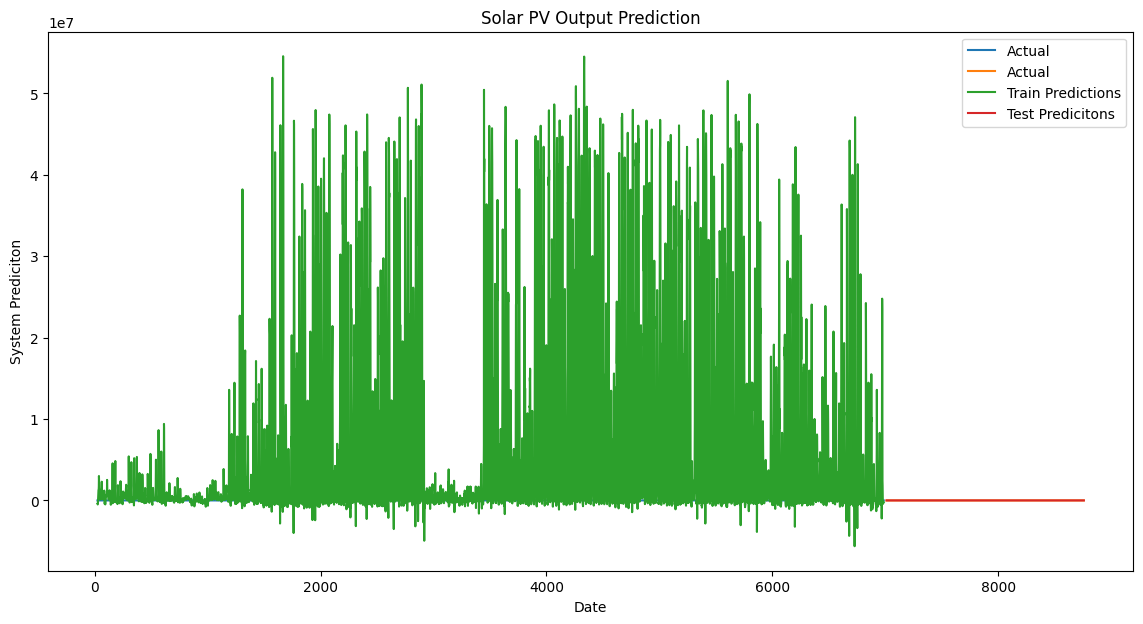

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[time_steps:split], df.iloc[time_steps:split, -1], label='Actual')
plt.plot(df.index[split+time_steps:], df.iloc[split+time_steps:, -1], label='Actual')
plt.plot(df.index[time_steps:split], train_predict[:df.index[time_steps:split].shape[0]], label='Train Predictions')
plt.plot(df.index[split+time_steps:], test_predict, label='Test Predicitons')
plt.title('Solar PV Output Prediction')
plt.xlabel('Date')
plt.ylabel('System Prediciton')
plt.legend()
plt.show()